In [46]:
import sys
sys.path.append('C:\\Users\\ryand\\git\\CheetahPy')
from cheetahpy import CheetahPy

In [104]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
cp = CheetahPy()

In [121]:
def plot_activity_summary(ac):
    fig, axs = plt.subplots(2, 2, figsize=(7,5))
    ac['kph'].plot(kind='hist', bins=40, title='KPH', ax=axs[0][0])
    ac[ac['lat']!=0][['lat','lon']].plot(x='lon',y='lat',title='Map', ax=axs[0][1])
    ac[ac['hr'] > ac['hr'].quantile(.05)]['hr'].plot(kind='hist', bins='fd', title='HR', color='red', ax=axs[1][0])
    ac['watts'].plot(kind='hist', bins='fd', title='Power', color='green', ax=axs[1][1])
    fig.tight_layout()

In [3]:
activ = cp.get_activities(athlete="Ryan Duecker"
                         ,start_date="2022/01/01"
                         ,end_date="2023/01/01"
                         ,activity_filenames_only=True)

223.75


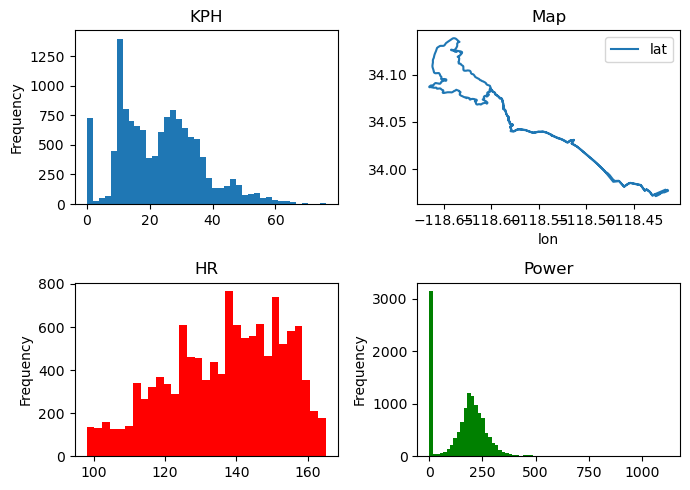

In [122]:
ac = cp.get_activity(athlete="Ryan Duecker"
                    ,activity_filename=activ[-16])
plot_activity_summary(ac)
print(ac['secs'].to_numpy()[-1]/60)

In [124]:
var_Ti = ac['temp'].mean()
var_HRi = ac['hr'].to_numpy()
var_PWRi = ac['watts'].to_numpy()
var_t = ac['secs'].to_numpy()
cons_lag = 15

## Genral Formula
# P_it = a_i + b_i*H_i,t+l + c*t*T_i
X = np.vstack((var_HRi[cons_lag:],(var_t[:-cons_lag] * var_Ti))).T
y = var_PWRi[:-cons_lag]

In [125]:
reg = LinearRegression(fit_intercept=True).fit(X, y)

In [126]:
y_hat = reg.predict(X)
errors = y - y_hat
(errors**2).sum()/errors.shape[0]

7511.155996089219

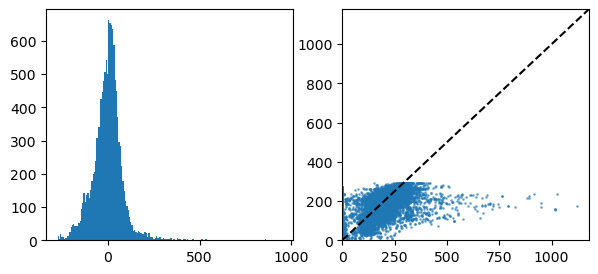

In [128]:
fig, axs = plt.subplots(1,2, figsize=(7,3))
axs[0].hist(errors, label='errors', bins='fd')
axs[1].plot(np.linspace(0,y.max()*1.25,5),np.linspace(0,y.max()*1.25,5), ls='--', color='black')
axs[1].scatter(y, y_hat, label='actual vs. predicted', s=1, alpha=.5)
axs[1].set_xlim(0,y.max()*1.05)
axs[1].set_ylim(0,y.max()*1.05);

In [129]:
reg.coef_

array([ 3.72496958e+00, -3.82583882e-04])